In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# Define the path to your dataset
dataset_path = '/content/drive/My Drive/Datasets/gaussian_filtered_images'

# Check if the file exists
if os.path.exists(dataset_path):
    print("Dataset found!")
else:
    print("Dataset not found!")


Dataset found!


In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


import matplotlib as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
import warnings
warnings.filterwarnings('ignore')

In [4]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00


In [6]:
from pathlib import Path

img_dir = '/content/drive/My Drive/Datasets/gaussian_filtered_images'
image_dir = Path(img_dir)
filepaths = list(image_dir.glob(r'**/*.png'))

labels = []
for filepath in filepaths:
    label = os.path.split(os.path.split(filepath)[0])[1]
    labels.append(label)

In [7]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')


df = pd.concat([filepaths, labels], axis=1)

df = df.sample(frac=1).reset_index(drop = True)

df.head(10)
df['Label'].value_counts()

Label
No_DR             1805
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: count, dtype: int64

In [8]:
import pandas as pd
from sklearn.utils import resample

n_samples = 400
label_counts = df['Label'].value_counts()
dfs_by_label_resampled = {}

# Iterate through each unique label in the DataFrame
for label in df['Label'].unique():
    label_count = label_counts.get(label, 0)  # Safely get the count of each label

    if label_count < n_samples:
        # If there are not enough samples, duplicate the existing ones to reach at least 400
        print(f"Label {label}: Not enough samples ({label_count}). Duplicating and resampling.")
        df_label = df[df['Label'] == label]
        # Duplicate rows to ensure we have enough samples
        num_repeats = (n_samples + label_count - 1) // label_count
        df_label_resampled = pd.concat([df_label] * num_repeats)
        df_label_resampled = df_label_resampled.sample(n_samples, replace=True, random_state=42)
    else:
        # If there are enough samples, resample to get exactly 400
        print(f"Label {label}: Enough samples ({label_count}). Resampling.")
        df_label_resampled = resample(df[df['Label'] == label], n_samples=n_samples, replace=True, random_state=42)

    # Append the resampled DataFrame to the dictionary
    dfs_by_label_resampled[label] = df_label_resampled

# Concatenate the resampled DataFrames
balanced_df = pd.concat(dfs_by_label_resampled.values())

# Shuffle the rows
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the class distribution after balancing
print(balanced_df['Label'].value_counts())


Label No_DR: Enough samples (1805). Resampling.
Label Proliferate_DR: Not enough samples (295). Duplicating and resampling.
Label Moderate: Enough samples (999). Resampling.
Label Severe: Not enough samples (193). Duplicating and resampling.
Label Mild: Not enough samples (370). Duplicating and resampling.
Label
Mild              400
No_DR             400
Severe            400
Moderate          400
Proliferate_DR    400
Name: count, dtype: int64


In [9]:
import plotly.express as px

Class_series = pd.Series(balanced_df['Label'])
lis = ["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]

DR_or_not = Class_series.value_counts().tolist()

data = {'Severity': lis, 'Count': DR_or_not}
df_plot = pd.DataFrame(data)

fig = px.bar(df_plot, x='Count', y='Severity', orientation='h',
             color='Severity', color_discrete_sequence=["skyblue", "black", "pink", "purple", "blue"],
             title='Percentage among the different Severities of DR')
fig.update_layout(yaxis={'categoryorder': 'total ascending'})
fig.show()

In [10]:
import glob
from PIL import Image

directory = '/content/drive/My Drive/Datasets/gaussian_filtered_images'

# Create a pattern to access all PNG files in the directory
pattern = os.path.join(directory, '*', '*.png')

# Use glob to get all file paths matching the pattern
image_paths = glob.glob(pattern)

size = (224, 224)


def load_image_and_resize(filepath):
        img = Image.open(filepath)
        img = img.resize(size)
        img = np.asarray(img)
        return img

balanced_df['image'] = balanced_df['Filepath'].map(lambda x: load_image_and_resize(x))
balanced_df['image']

0       [[[128, 128, 128], [128, 128, 128], [132, 131,...
1       [[[128, 128, 128], [128, 128, 128], [137, 137,...
2       [[[124, 124, 124], [132, 128, 128], [128, 126,...
3       [[[132, 128, 128], [128, 124, 124], [127, 124,...
4       [[[128, 128, 128], [128, 128, 128], [127, 127,...
                              ...                        
1995    [[[128, 128, 128], [128, 128, 128], [128, 128,...
1996    [[[125, 125, 121], [129, 125, 133], [124, 120,...
1997    [[[132, 132, 132], [128, 132, 128], [128, 128,...
1998    [[[126, 126, 126], [129, 129, 123], [131, 128,...
1999    [[[124, 128, 128], [133, 129, 129], [130, 131,...
Name: image, Length: 2000, dtype: object

In [11]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
sampled_images = balanced_df['image'].sample(6, random_state=42)
size = (224, 224)
sampled_images = [Image.fromarray(img).resize(size) for img in sampled_images]

sampled_images = [np.array(img) for img in sampled_images]

fig = make_subplots(rows=2, cols=3, subplot_titles=("Image 1", "Image 2", "Image 3", "Image 4", "Image 5", "Image 6"))

for i, img in enumerate(sampled_images, start=1):
    fig.add_trace(go.Image(z=img), row=(i-1) // 3 + 1, col=(i-1) % 3 + 1)

fig.update_layout(
    title="Sample Images",
    width=800,
    height=600,
    margin=dict(l=20, r=20, t=60, b=20),
)

fig.show()

In [13]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Assuming 'Label' column contains categorical string labels
# Create a mapping from string labels to integer labels
label_mapping = {'No_DR': 0, 'Mild_DR': 1, 'Moderate_DR': 2, 'Severe_DR': 3, 'Proliferate_DR': 4}
balanced_df['Label_int'] = balanced_df['Label'].map(label_mapping)

# Check for NaNs in the integer labels column
print("NaNs in 'Label_int' column:", balanced_df['Label_int'].isna().sum())

# Check the unique values in 'Label_int' column
print("Unique values in 'Label_int' column:", balanced_df['Label_int'].unique())

# If there are NaNs, print the rows with NaNs
if balanced_df['Label_int'].isna().sum() > 0:
    print("Rows with NaNs in 'Label_int':")
    print(balanced_df[balanced_df['Label_int'].isna()])

# Remove rows with NaNs in 'Label_int' if any
balanced_df = balanced_df.dropna(subset=['Label_int'])

# Convert images to NumPy array and normalize
x = np.asarray(balanced_df['image'].to_list())
x = x / 255.0

# Convert labels to integer and then to one-hot encoding
y = balanced_df['Label_int']

# Ensure all labels are valid integers before converting to categorical
assert y.min() >= 0 and y.max() < 5, "Labels out of expected range (0 to 4)."

# Convert labels to one-hot encoding
y = to_categorical(y, num_classes=5)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

# Check the shapes of the training and testing data
print("Data preprocessing complete. Shapes:")
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


NaNs in 'Label_int' column: 1200
Unique values in 'Label_int' column: [nan  0.  4.]
Rows with NaNs in 'Label_int':
                                               Filepath     Label  \
0     /content/drive/My Drive/Datasets/gaussian_filt...      Mild   
2     /content/drive/My Drive/Datasets/gaussian_filt...    Severe   
3     /content/drive/My Drive/Datasets/gaussian_filt...  Moderate   
4     /content/drive/My Drive/Datasets/gaussian_filt...    Severe   
5     /content/drive/My Drive/Datasets/gaussian_filt...    Severe   
...                                                 ...       ...   
1995  /content/drive/My Drive/Datasets/gaussian_filt...  Moderate   
1996  /content/drive/My Drive/Datasets/gaussian_filt...    Severe   
1997  /content/drive/My Drive/Datasets/gaussian_filt...  Moderate   
1998  /content/drive/My Drive/Datasets/gaussian_filt...    Severe   
1999  /content/drive/My Drive/Datasets/gaussian_filt...  Moderate   

                                                  image 

In [14]:
import logging
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import Callback

# Setup logging
log_file = "UPDATED-Xception_Training.log"
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s', handlers=[logging.FileHandler(log_file), logging.StreamHandler()])

class LoggingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logging.info(f"Epoch {epoch + 1}: {logs}")

# Load DenseNet-121 model without top layers
vgg = Xception(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
vgg.trainable = False

# Create the model
x = Flatten()(vgg.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
prediction = Dense(5, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)

# Compile the model
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model without early stopping
history = model.fit(x_train, y_train, epochs=70, batch_size=8, validation_data=(x_test, y_test), callbacks=[LoggingCallback()])

# Save the model
model.save("/content/drive/My Drive/Datasets/saved_models/Xception.h5")

# Print the results
print(history.history)


83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/70
80/80 [==============================] - 398s 5s/step - loss: 0.3229 - accuracy: 0.9125 - val_loss: 0.4566 - val_accuracy: 0.9438
Epoch 2/70
80/80 [==============================] - 444s 6s/step - loss: 0.1957 - accuracy: 0.9531 - val_loss: 0.5877 - val_accuracy: 0.9563
Epoch 3/70
80/80 [==============================] - 392s 5s/step - loss: 0.1841 - accuracy: 0.9563 - val_loss: 1.0513 - val_accuracy: 0.9250
Epoch 4/70
80/80 [==============================] - 358s 4s/step - loss: 0.1521 - accuracy: 0.9703 - val_loss: 0.5635 - val_accuracy: 0.9438
Epoch 5/70
80/80 [==============================] - 369s 5s/step - loss: 0.1282 - accuracy: 0.9734 - val_loss: 0.7898 - val_accuracy: 0.9563
Epoch 6/70
80/80 [==============================] - 349s 4s/step - loss: 0.0665 - accuracy: 0.9875 - val_loss: 1.0495 - val_accuracy: 0.9438
Epoch 7/70
80/80 [==============================] - 353s 4s/step - loss: 0.1249 - accurac

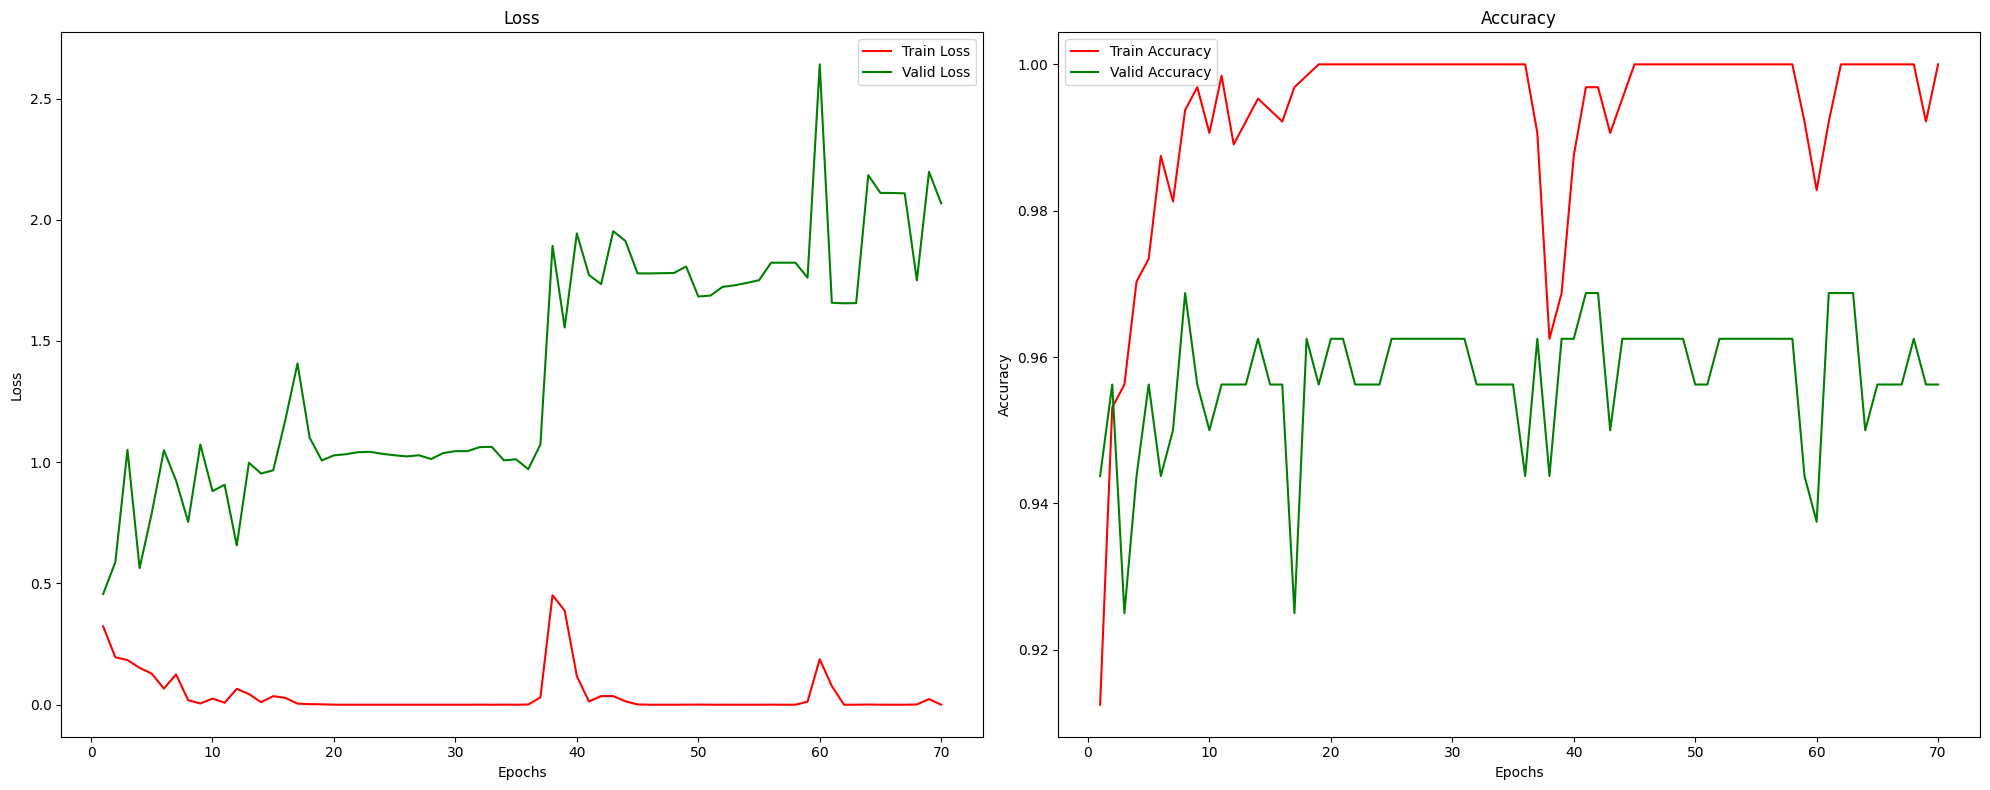

In [15]:
import matplotlib.pyplot as plt
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


In [16]:
from tensorflow.keras.models import load_model

# Path where your model is saved
model_path = '/content/drive/My Drive/Datasets/saved_models/Xception.h5'

# Load the saved model
model = load_model(model_path)

In [18]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to your single image file
img_path = '/content/drive/My Drive/Datasets/gaussian_filtered_images/Proliferate_DR/4dd71fc7f22b.png'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to create batch of size 1
img_array /= 255.  # Normalize pixel values to [0, 1]


predictions = model.predict(img_array)

predicted_class_index = np.argmax(predictions, axis=1)[0]

print(f'Predicted class index: {predicted_class_index}')

class_labels = ['Severe', 'Moderate', 'No_DR', 'Mild', 'Proliferate_DR']  # Replace with your actual class labels
predicted_class_label = class_labels[predicted_class_index]

print(f'Predicted class label: {predicted_class_label}')


1/1 [==============================] - 2s 2s/step
Predicted class index: 0
Predicted class label: Severe


In [20]:
# Extract training and validation metrics
tr_acc, tr_loss = history.history['accuracy'], history.history['loss']
val_acc, val_loss = history.history['val_accuracy'], history.history['val_loss']

# Calculate mean, max, and min for training and validation metrics
metrics = {
    'Training Accuracy': (tr_acc, 'tr_acc'),
    'Training Loss': (tr_loss, 'tr_loss'),
    'Validation Accuracy': (val_acc, 'val_acc'),
    'Validation Loss': (val_loss, 'val_loss')
}

results = {}
for name, (values, var_name) in metrics.items():
    mean, max_val, min_val = np.mean(values), np.max(values), np.min(values)
    results[var_name + '_mean'] = mean
    results[var_name + '_max'] = max_val
    results[var_name + '_min'] = min_val
    print(f"{name} - Mean: {mean:.4f}, Max: {max_val:.4f}, Min: {min_val:.4f}")



Training Accuracy - Mean: 0.9931, Max: 1.0000, Min: 0.9125
Training Loss - Mean: 0.0402, Max: 0.4514, Min: 0.0000
Validation Accuracy - Mean: 0.9572, Max: 0.9688, Min: 0.9250
Validation Loss - Mean: 1.3895, Max: 2.6410, Min: 0.4566
